**Import Libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

%matplotlib inline

**Uloading Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['heart.csv']))

df.head()

Saving heart.csv to heart.csv


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
plt.rcParams['figure.dpi'] = 200

sns.set(rc={'axes.facecolor': '#faded9'}, style='darkgrid')

**Dataset Overview**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

,0
age,int64
sex,object
cp,object
trestbps,int64
chol,int64
fbs,object
restecg,object
thalach,int64
exang,object
oldpeak,float64


In [ ]:
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


**Exploratory Data Analysis**

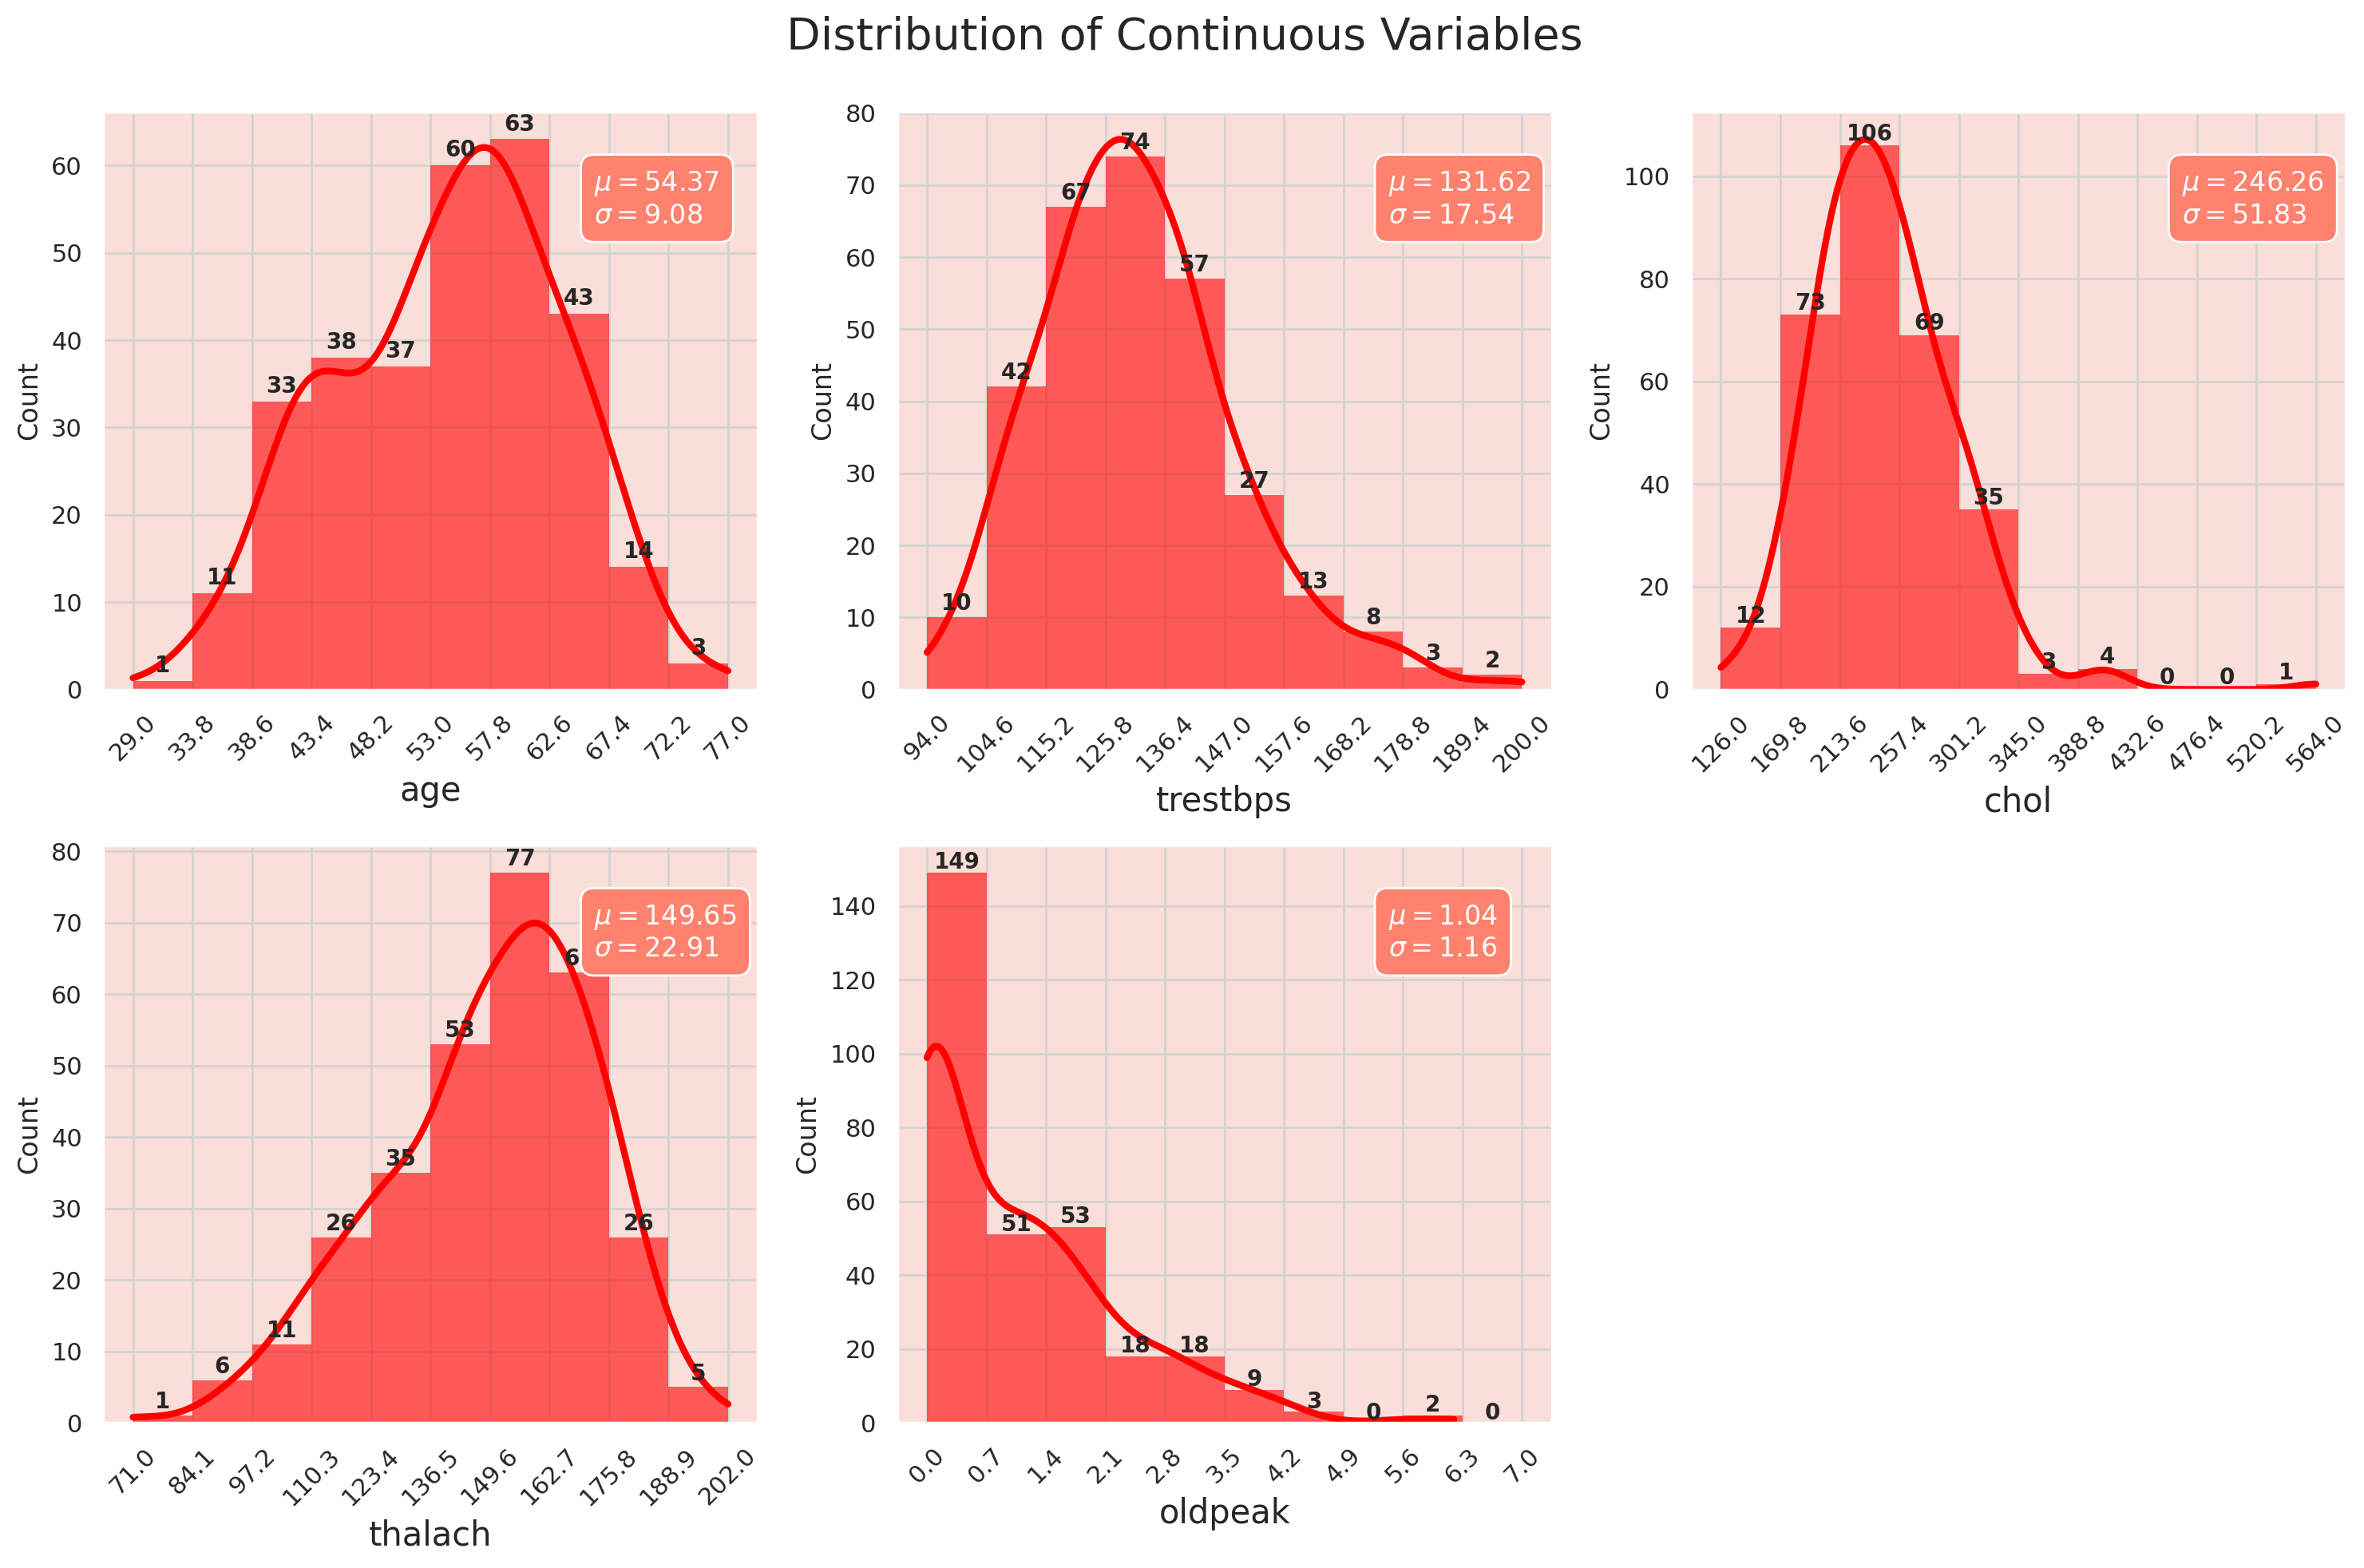

In [ ]:
df_continuous = df[continuous_features]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col],
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))

    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')

    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")

    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [ ]:
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

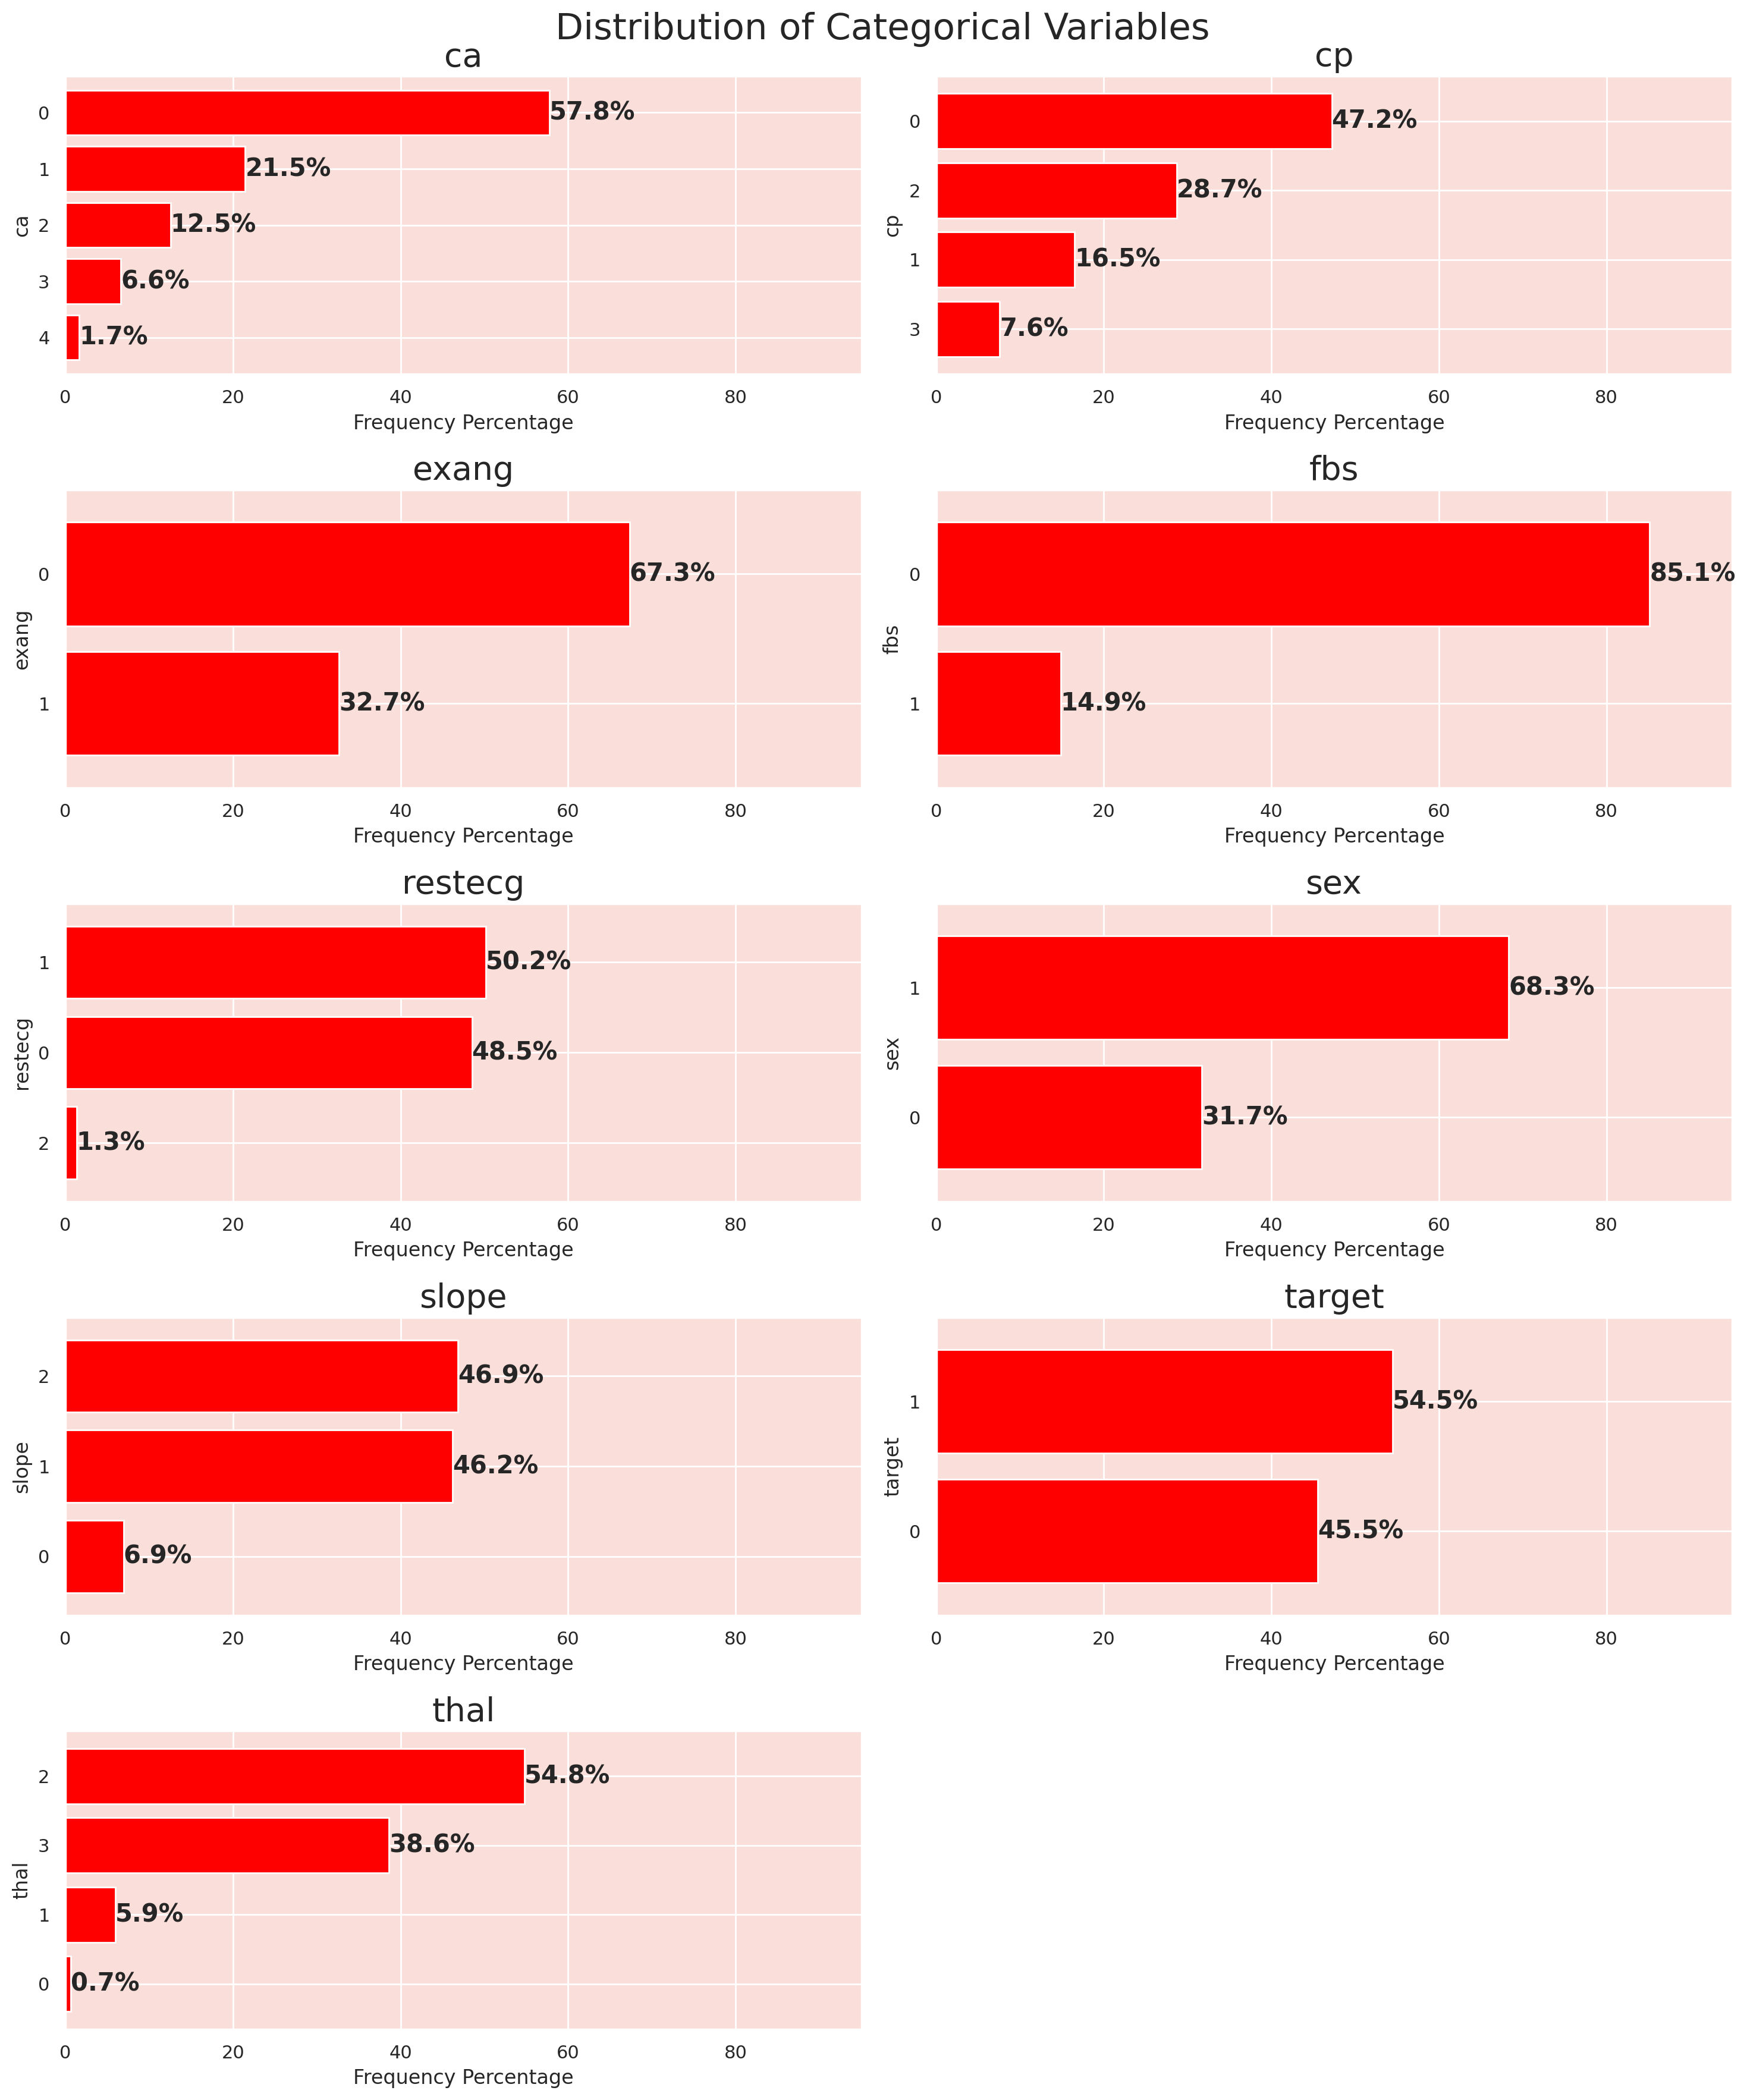

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2

    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()

    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='red')

    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')

    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)

ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

Categorical Features vs Target

In [ ]:
categorical_features = [feature for feature in categorical_features if feature != 'target']

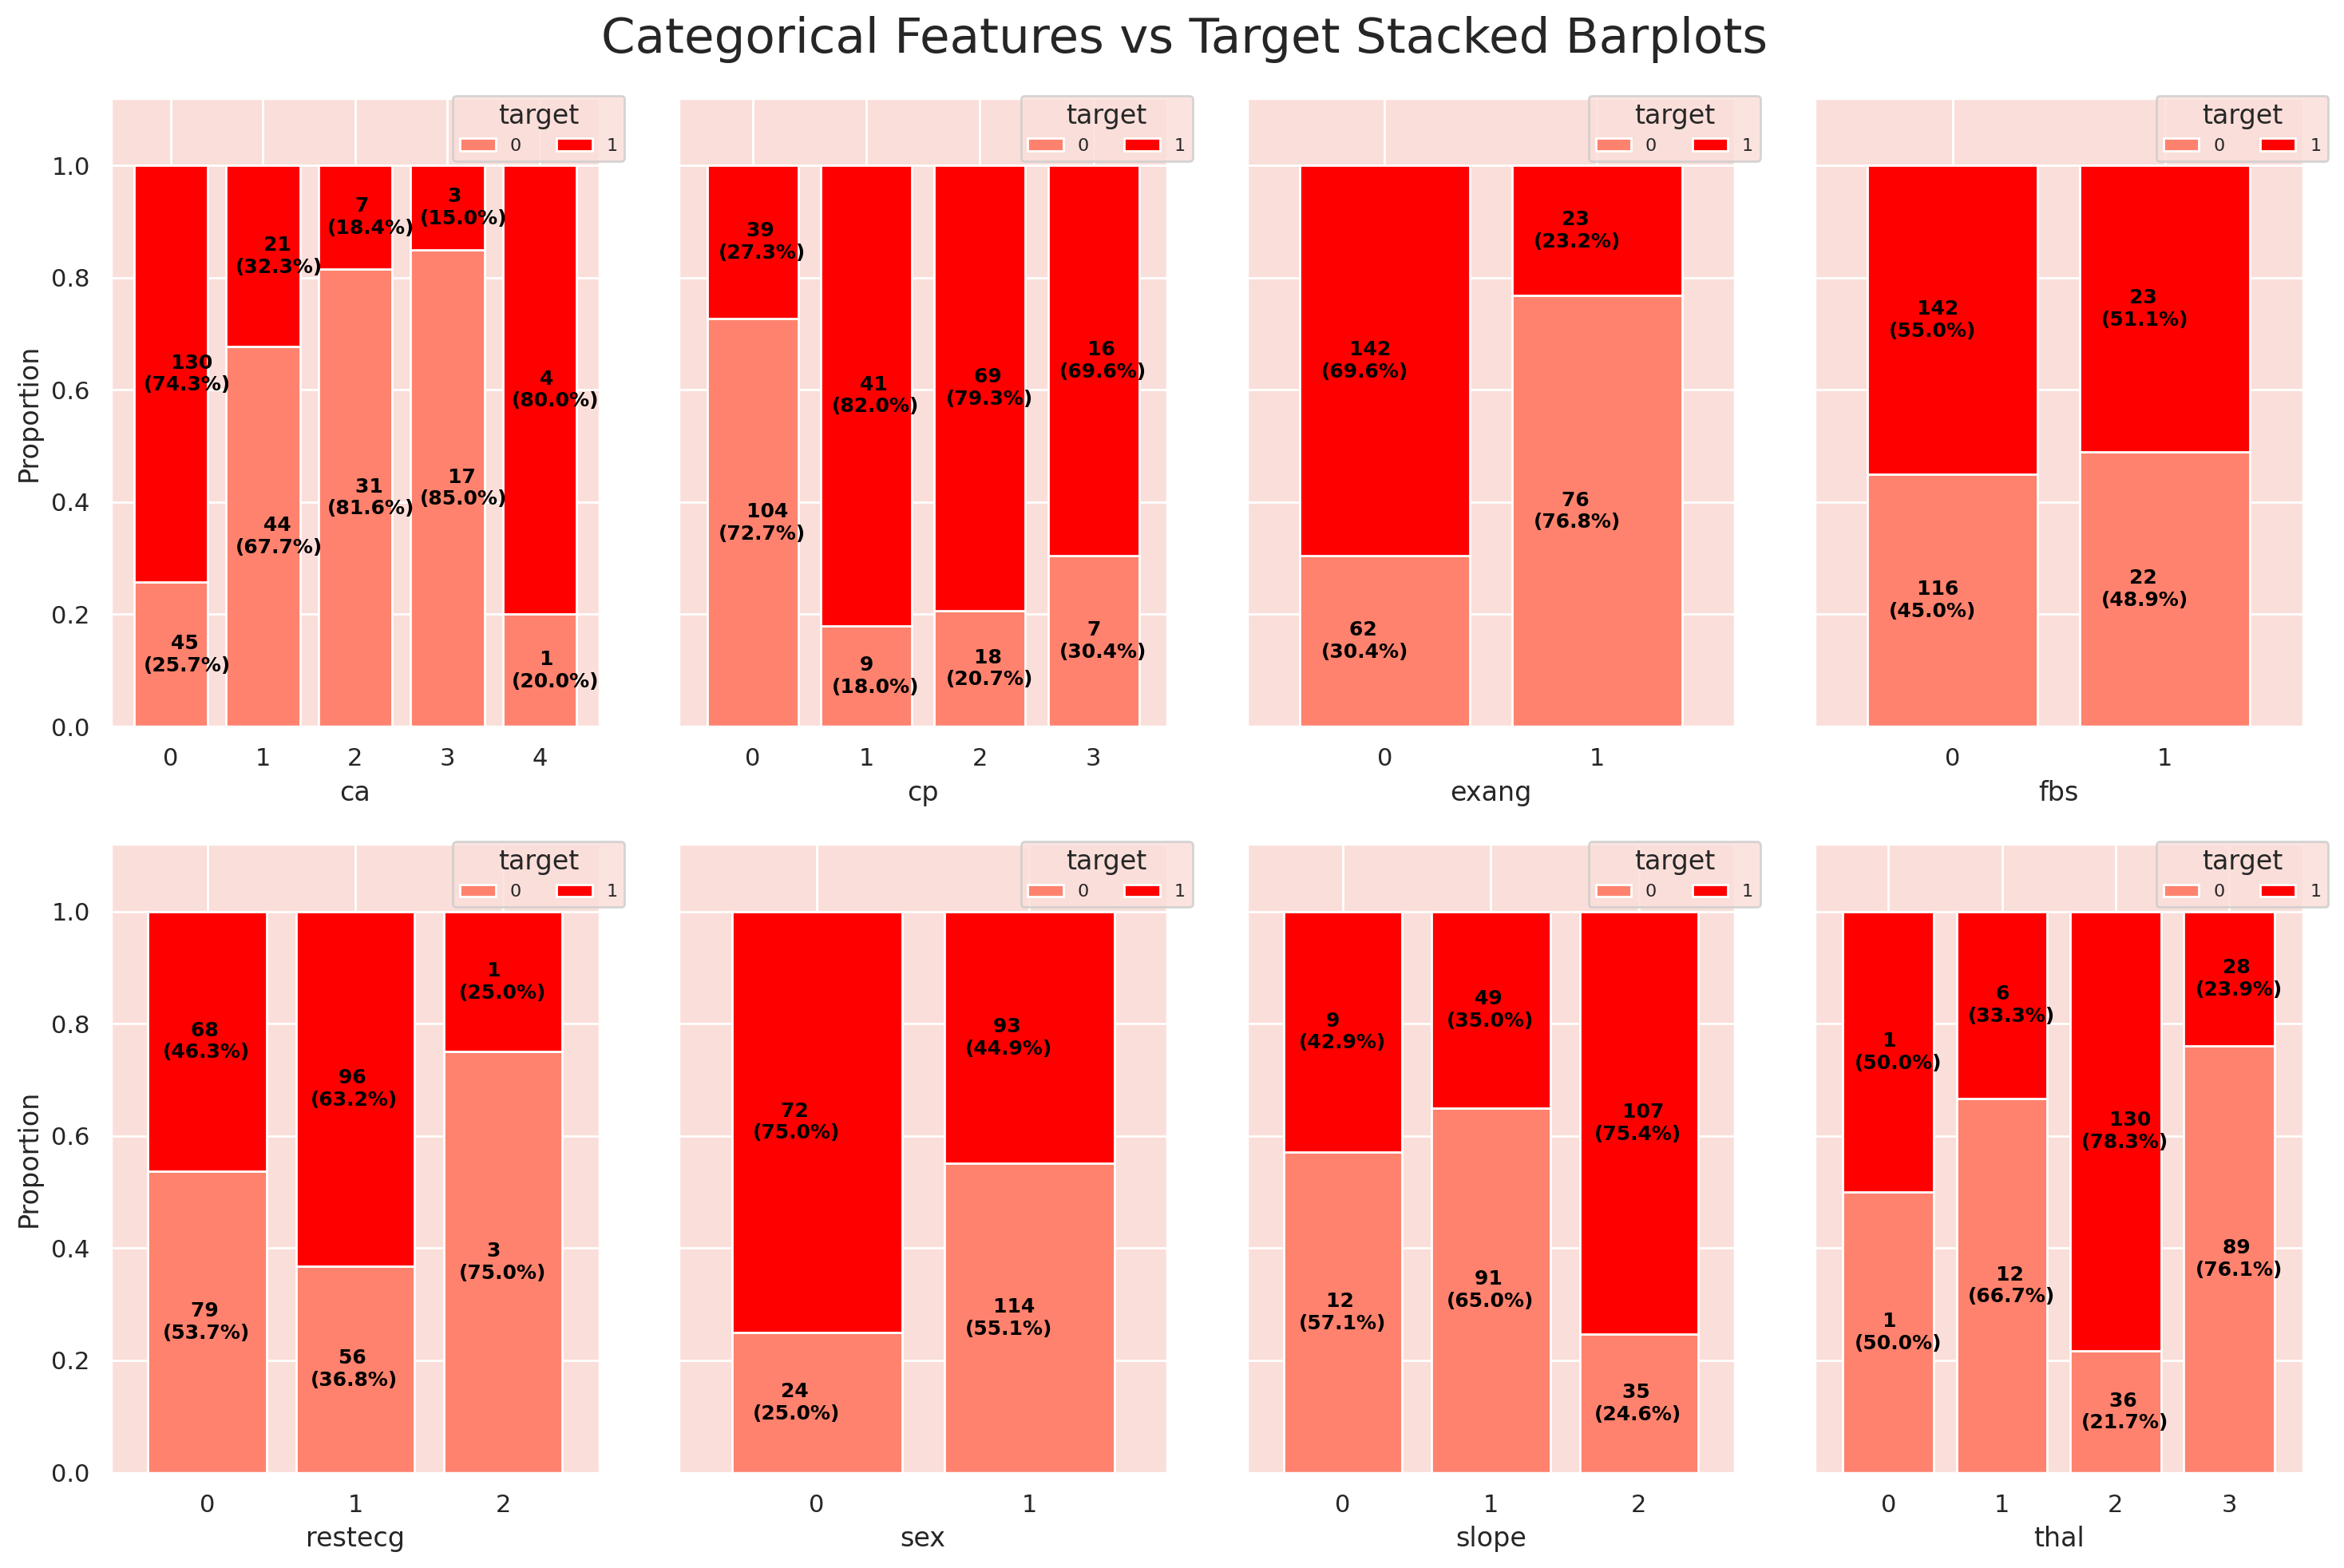

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):

    cross_tab = pd.crosstab(index=df[col], columns=df['target'])

    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')

    cmp = ListedColormap(['#ff826e', 'red'])

    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)

    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)',
                         color = "black", fontsize=9, fontweight="bold")

    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    ax[x,y].set_ylim([0,1.12])
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)


plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()
plt.show()

**Data Preprocessing**

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [ ]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

,0
age,0
trestbps,9
chol,5
thalach,1
oldpeak,5


In [ ]:
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes

,0
age,int64
sex,int64
trestbps,int64
chol,int64
fbs,int64
thalach,int64
exang,int64
oldpeak,float64
slope,int64
ca,int64


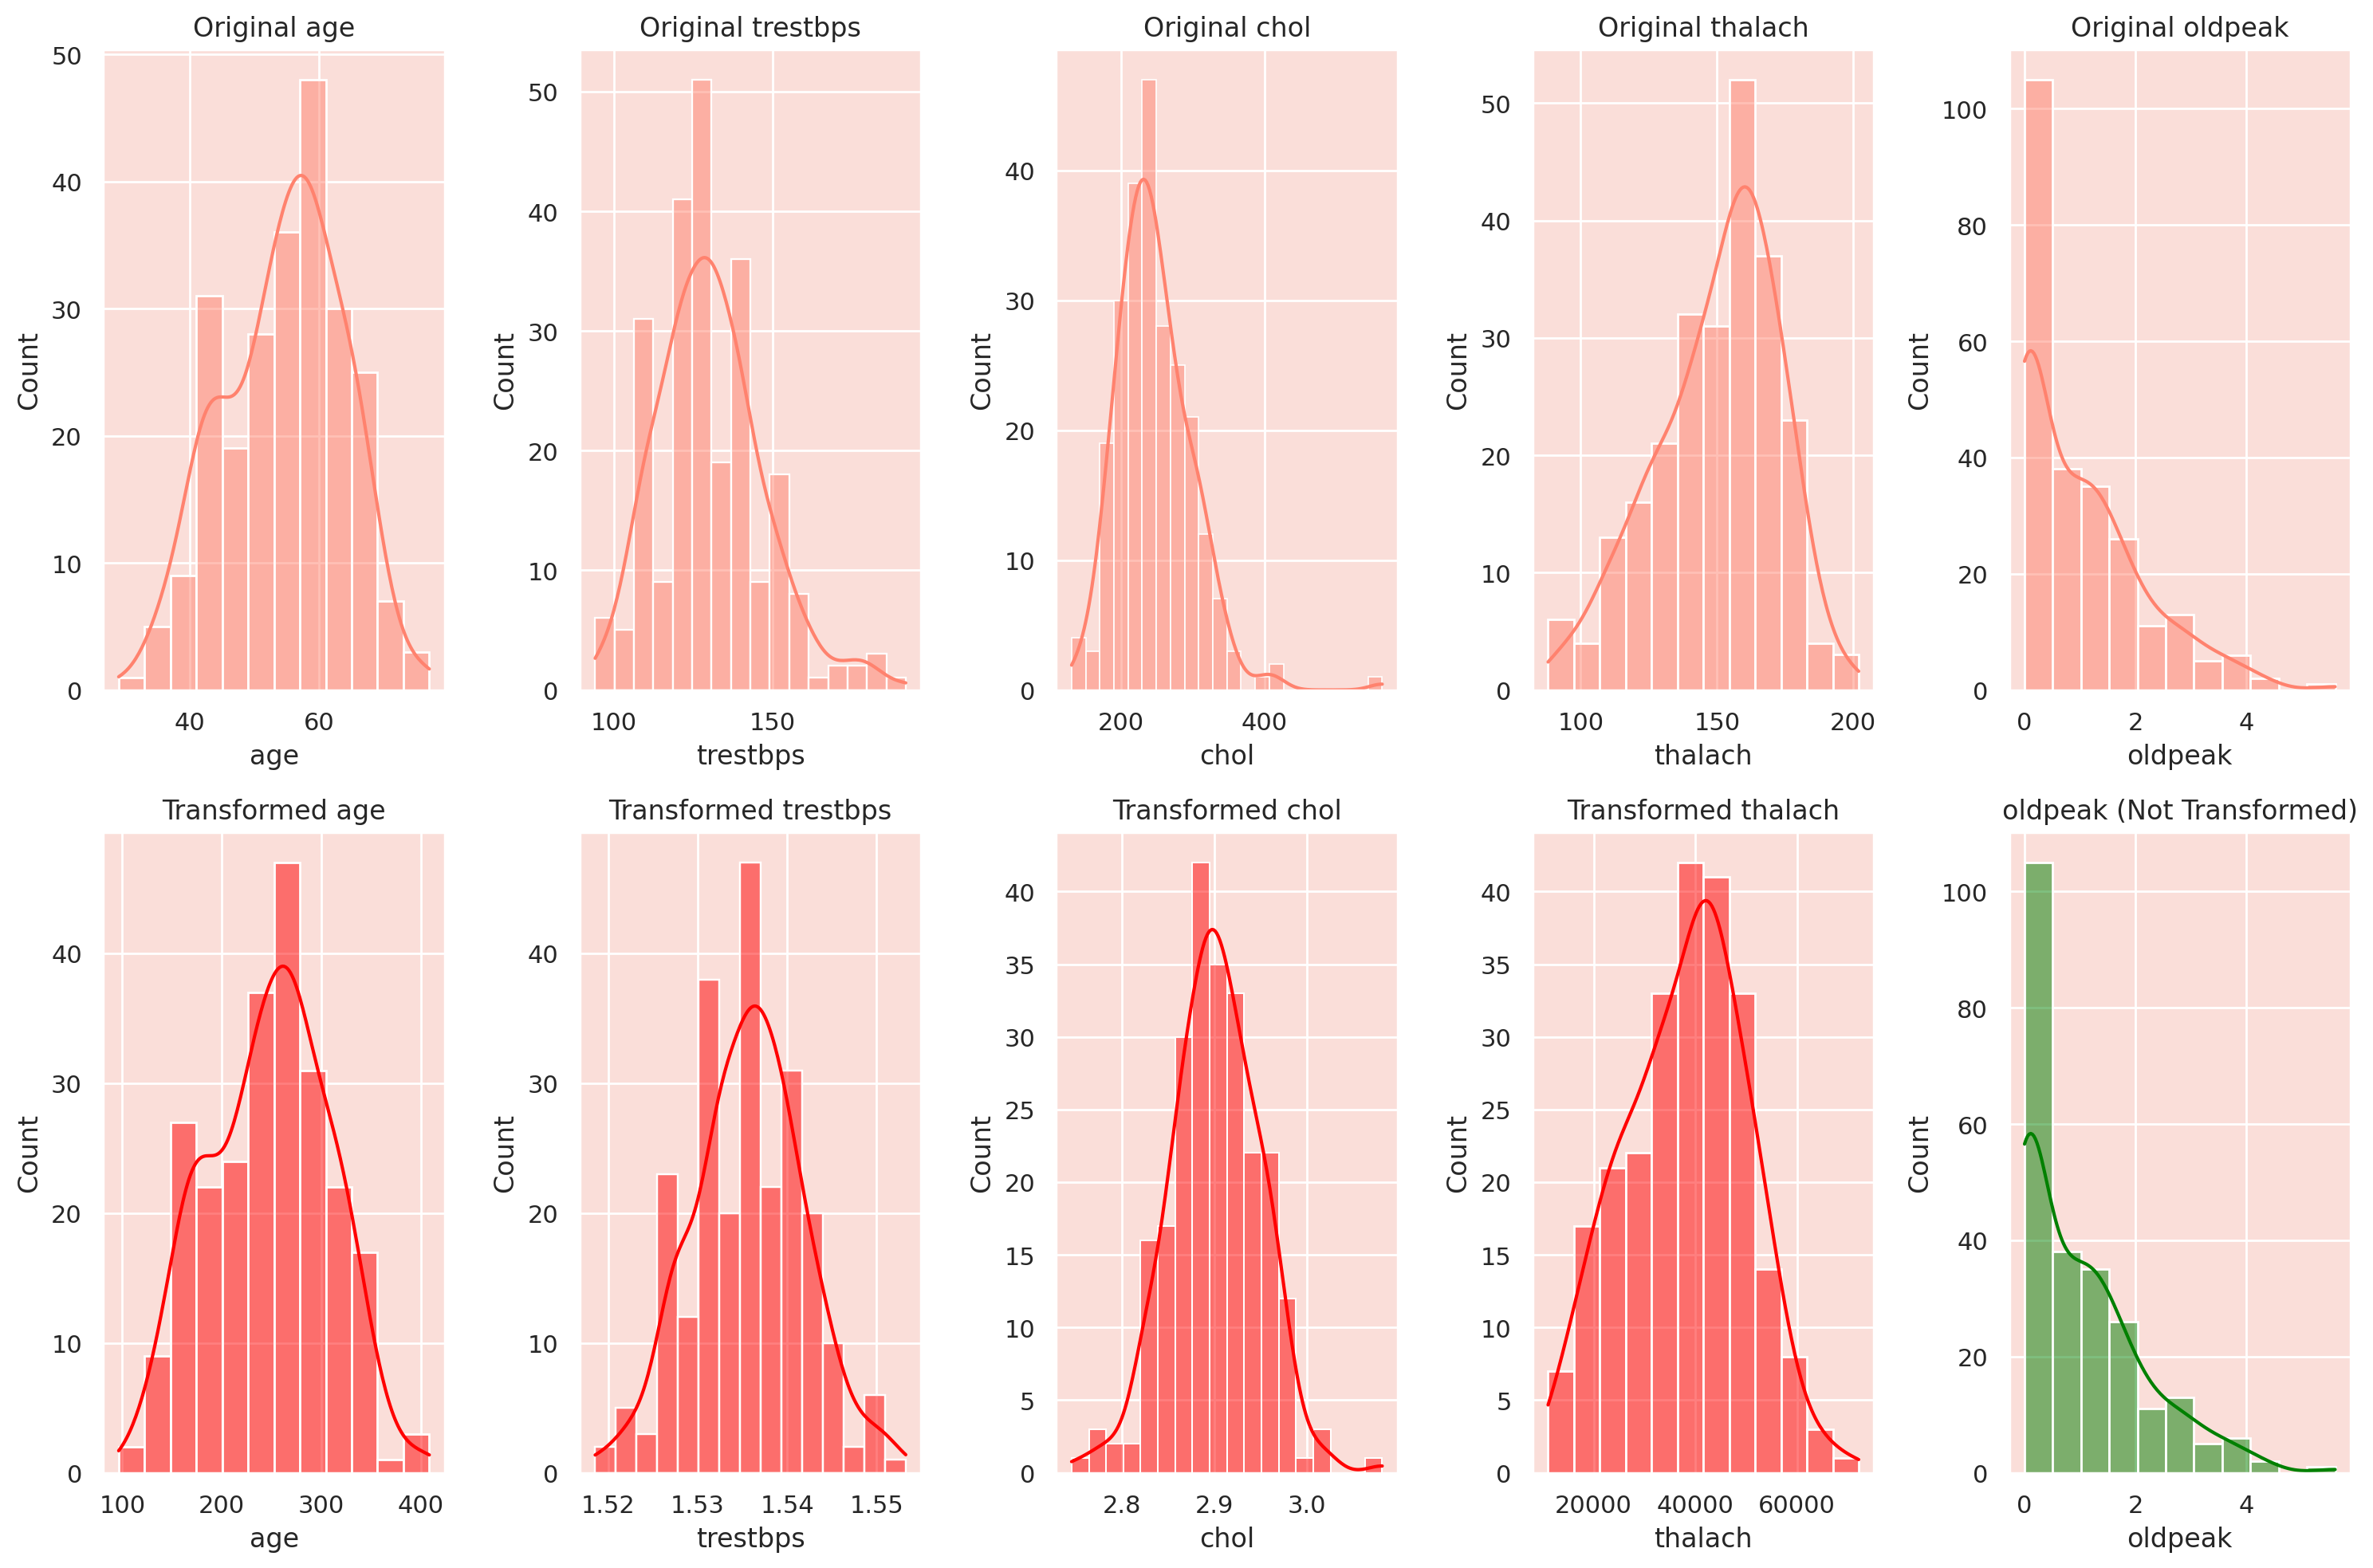

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15,10))

from sklearn.model_selection import train_test_split
X = df_encoded[continuous_features]
y = df_encoded['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Splitting the data

for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0,i], color='#ff826e').set_title(f'Original {col}')


lambdas = {}

for i, col in enumerate(continuous_features):
    if X_train[col].min() > 0:
        X_train[col], lambdas[col] = boxcox(X_train[col])
        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col])
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='red').set_title(f'Transformed {col}')
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='green').set_title(f'{col} (Not Transformed)')

fig.tight_layout()
plt.show()

**KNN Model Building**

In [ ]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

KNN Hyperparameter Tuning

In [ ]:
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 12)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

In [ ]:
from sklearn.model_selection import GridSearchCV


def tune_clf_hyperparameters(pipeline, param_grid, X_train, y_train):
    """
    Tunes the hyperparameters of a classifier using GridSearchCV.

    Args:
        pipeline: The pipeline containing the classifier.
        param_grid: The hyperparameter grid to search.
        X_train: The training data.
        y_train: The training labels.

    Returns:
        The best estimator and the best hyperparameters found.
    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, y_train)
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

KNN Optimal Hyperparameters: 
 {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'distance'}


In [ ]:
print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00       133

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242



In [ ]:
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.62      0.68        29
           1       0.70      0.81      0.75        32

    accuracy                           0.72        61
   macro avg       0.73      0.72      0.72        61
weighted avg       0.73      0.72      0.72        61



**Dataset Source:** https://www.kaggle.com/code/farzadnekouei/heart-disease-prediction/input